# Machine Learning to Identify Fraud in the Enron Corpus

In [782]:
import warnings 
warnings.filterwarnings("ignore")
import sys
import pickle
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
import pandas as pd
import sys
import pickle
import csv
import matplotlib.pyplot as plt

sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
#from poi_data import *
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

from numpy import mean
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

from sklearn.metrics import accuracy_score, precision_score, recall_score

## Task 1: Select what features you'll use

features_list is a list of strings, each of which is a feature name.    
The first feature must be "poi".    
features_list = ['poi','salary']    
**You will need to use more features**

In [783]:
target_label = 'poi'

email_features_list = [
    'from_messages',
    'from_poi_to_this_person',
    'from_this_person_to_poi',
    'shared_receipt_with_poi',
    'to_messages',
    ]
    
financial_features_list = [
    'bonus',
    'deferral_payments',
    'deferred_income',
    'director_fees',
    'exercised_stock_options',
    'expenses',
    'loan_advances',
    'long_term_incentive',
    'other',
    'restricted_stock',
    'restricted_stock_deferred',
    'salary',
    'total_payments',
    'total_stock_value',
]

features_list = [target_label] + financial_features_list + email_features_list

In [784]:
### Load the dictionary containing the dataset

with open('final_project_dataset.pkl', 'rb') as data_file:
    data_dict = pickle.load(data_file)

In [785]:
df = pd.DataFrame(data_dict)
#df['LOCKHART EUGENE E']
df.T

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
METTS MARK,365788,807,NaN,1061827,NaN,600000,mark.metts@enron.com,NaN,NaN,585062,...,38,NaN,29,1740,1,False,NaN,702,585062,NaN
BAXTER JOHN C,267102,NaN,1295738,5634343,NaN,1200000,NaN,NaN,-1386055,10623258,...,NaN,6680544,NaN,2660303,NaN,False,1586055,NaN,3942714,NaN
ELLIOTT STEVEN,170941,NaN,NaN,211725,NaN,350000,steven.elliott@enron.com,NaN,-400729,6678735,...,NaN,4890344,NaN,12961,NaN,False,NaN,NaN,1788391,NaN
CORDES WILLIAM R,NaN,764,NaN,NaN,NaN,NaN,bill.cordes@enron.com,NaN,NaN,1038185,...,10,651850,12,NaN,0,False,NaN,58,386335,NaN
HANNON KEVIN P,243293,1045,NaN,288682,NaN,1500000,kevin.hannon@enron.com,NaN,-3117011,6391065,...,32,5538001,32,11350,21,True,1617011,1035,853064,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GRAMM WENDY L,NaN,NaN,NaN,119292,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,119292
CAUSEY RICHARD A,415189,1892,NaN,1868758,NaN,1000000,richard.causey@enron.com,NaN,-235000,2502063,...,58,NaN,49,307895,12,True,350000,1585,2502063,NaN
TAYLOR MITCHELL S,265214,533,227449,1092663,NaN,600000,mitchell.taylor@enron.com,NaN,NaN,3745048,...,0,3181250,29,NaN,0,False,NaN,300,563798,NaN
DONAHUE JR JEFFREY M,278601,865,NaN,875760,NaN,800000,jeff.donahue@enron.com,NaN,-300000,1080988,...,188,765920,22,891,11,False,NaN,772,315068,NaN


### 1.1.0 Explore csv file 

In [786]:
def make_csv(data_dict):
    """ generates a csv file from a data set"""
    fieldnames = ['name'] + data_dict.itervalues().next().keys()
    with open('data.csv', 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for record in data_dict:
            person = data_dict[record]
            person['name'] = record
            assert set(person.keys()) == set(fieldnames)
            writer.writerow(person)

### 1.1.1 Dataset Exploration

In [787]:
print('# Exploratory Data Analysis #')
data_dict.keys()
print('Total number of data points: %d' % len(data_dict.keys()))
num_poi = 0
for name in data_dict.keys():
    if data_dict[name]['poi'] == True:
        num_poi += 1
print('Number of Persons of Interest: %d' % num_poi)
print('Number of people without Person of Interest label: %d' % (len(data_dict.keys()) - num_poi))

# Exploratory Data Analysis #
Total number of data points: 146
Number of Persons of Interest: 18
Number of people without Person of Interest label: 128


### 1.1.2 Feature Exploration

In [788]:
all_features = data_dict['ALLEN PHILLIP K'].keys()
print('Each person has %d features available' %  len(all_features))
### Evaluate dataset for completeness
missing_values = {}
for feature in all_features:
    missing_values[feature] = 0
for person in data_dict.keys():
    records = 0
    for feature in all_features:
        if data_dict[person][feature] == 'NaN':
            missing_values[feature] += 1
        else:
            records += 1

Each person has 21 features available


### Print results of completeness analysis

In [789]:
print('Number of Missing Values for Each Feature:')

#sorted(missing_values.values())

#for feature in all_features:
   # print("%s: %d" % (feature, sorted(missing_values.values())[feature])


for id in sorted(missing_values, key = missing_values.get, reverse = True):
          print(id, missing_values[id])


Number of Missing Values for Each Feature:
loan_advances 142
director_fees 129
restricted_stock_deferred 128
deferral_payments 107
deferred_income 97
long_term_incentive 80
bonus 64
to_messages 60
from_poi_to_this_person 60
from_messages 60
from_this_person_to_poi 60
shared_receipt_with_poi 60
other 53
salary 51
expenses 51
exercised_stock_options 44
restricted_stock 36
email_address 35
total_payments 21
total_stock_value 20
poi 0


=> classification,we have here unblanced target. 
Maybe Smot methodology ? 

## Task 2: Remove outliers

In [790]:
def PlotOutlier(data_dict, feature_x, feature_y):
    """ Plot with flag = True in Red """
    data = featureFormat(data_dict, [feature_x, feature_y, 'poi'])
    for point in data:
        x = point[0]
        y = point[1]
        poi = point[2]
        if poi:
            color = 'red'
        else:
            color = 'blue'
        plt.scatter(x, y, color=color)
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.show()

### 2.1 Visualise outliers

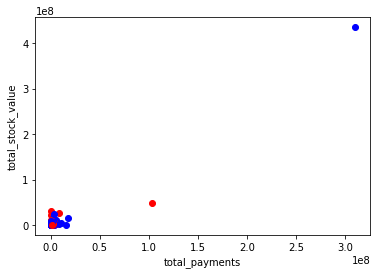

None


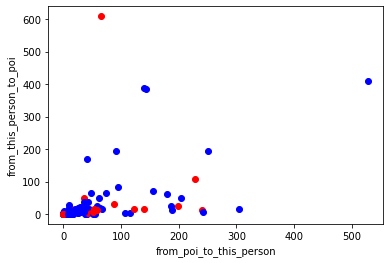

None


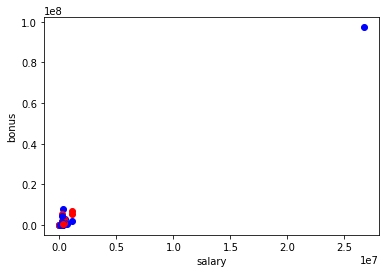

None


{'salary': 26704229,
 'to_messages': 'NaN',
 'deferral_payments': 32083396,
 'total_payments': 309886585,
 'loan_advances': 83925000,
 'bonus': 97343619,
 'email_address': 'NaN',
 'restricted_stock_deferred': -7576788,
 'deferred_income': -27992891,
 'total_stock_value': 434509511,
 'expenses': 5235198,
 'from_poi_to_this_person': 'NaN',
 'exercised_stock_options': 311764000,
 'from_messages': 'NaN',
 'other': 42667589,
 'from_this_person_to_poi': 'NaN',
 'poi': False,
 'long_term_incentive': 48521928,
 'shared_receipt_with_poi': 'NaN',
 'restricted_stock': 130322299,
 'director_fees': 1398517}

In [791]:
print(PlotOutlier(data_dict, 'total_payments', 'total_stock_value'))
print(PlotOutlier(data_dict, 'from_poi_to_this_person', 'from_this_person_to_poi'))
print(PlotOutlier(data_dict, 'salary', 'bonus'))
#Remove outlier TOTAL line in pickle file.
data_dict.pop( 'TOTAL', 0 )

### 2.2 Function to remove outliers

In [792]:
def remove_outlier(dict_object, keys):
    """ removes list of outliers keys from dict object """
    for key in keys:
        dict_object.pop(key, 0)

outliers = ['TOTAL', 'THE TRAVEL AGENCY IN THE PARK', 'LOCKHART EUGENE E']
remove_outlier(data_dict, outliers)

=>Remove columns   
Maybe more outliers ? 

### Task 3: Create new feature(s)

### 3.1 create new copies of dataset for grading

In [794]:
my_dataset = data_dict

### 3.2 add new features to dataset

In [795]:
def compute_fraction(poi_messages, all_messages):
    """ return fraction of messages from/to that person to/from POI"""    
    if poi_messages == 'NaN' or all_messages == 'NaN':
        return 0.
    fraction = poi_messages / all_messages
    return fraction

In [796]:
for name in my_dataset:
    data_point = my_dataset[name]
    from_poi_to_this_person = data_point["from_poi_to_this_person"]
    to_messages = data_point["to_messages"]
    fraction_from_poi = compute_fraction(from_poi_to_this_person, to_messages)
    data_point["fraction_from_poi"] = fraction_from_poi
    from_this_person_to_poi = data_point["from_this_person_to_poi"]
    from_messages = data_point["from_messages"]
    fraction_to_poi = compute_fraction(from_this_person_to_poi, from_messages)
    data_point["fraction_to_poi"] = fraction_to_poi
    
    shared_receipt_with_poi = data_point["shared_receipt_with_poi"]
    shared_receipt_poi_ratio = compute_fraction(shared_receipt_with_poi, to_messages)
    data_point["shared_receipt_poi_ratio"] = shared_receipt_poi_ratio
    
    bonus= data_point["bonus"]
    salary = data_point["salary"]
    bonus_to_salary = compute_fraction(bonus, salary)
    data_point["bonus_to_salary"] = bonus_to_salary  
    
    total_payments = data_point["total_payments"]
    bonus_to_salary = compute_fraction(total_payments, salary)
    data_point["bonus_to_total"] = bonus_to_salary  
    
    x = float(from_poi_to_this_person) + float(from_this_person_to_poi)
    y = float(from_messages) + float(to_messages)
    ratio_mess= compute_fraction(x,y)
    data_point["ratio_mess"] = ratio_mess 

In [797]:
my_dataset.keys()

dict_keys(['METTS MARK', 'BAXTER JOHN C', 'ELLIOTT STEVEN', 'CORDES WILLIAM R', 'HANNON KEVIN P', 'MORDAUNT KRISTINA M', 'MEYER ROCKFORD G', 'MCMAHON JEFFREY', 'HAEDICKE MARK E', 'PIPER GREGORY F', 'HUMPHREY GENE E', 'NOLES JAMES L', 'BLACHMAN JEREMY M', 'SUNDE MARTIN', 'GIBBS DANA R', 'LOWRY CHARLES P', 'COLWELL WESLEY', 'MULLER MARK S', 'JACKSON CHARLENE R', 'WESTFAHL RICHARD K', 'WALTERS GARETH W', 'WALLS JR ROBERT H', 'KITCHEN LOUISE', 'CHAN RONNIE', 'BELFER ROBERT', 'SHANKMAN JEFFREY A', 'WODRASKA JOHN', 'BERGSIEKER RICHARD P', 'URQUHART JOHN A', 'BIBI PHILIPPE A', 'RIEKER PAULA H', 'WHALEY DAVID A', 'BECK SALLY W', 'HAUG DAVID L', 'ECHOLS JOHN B', 'MENDELSOHN JOHN', 'HICKERSON GARY J', 'CLINE KENNETH W', 'LEWIS RICHARD', 'HAYES ROBERT E', 'KOPPER MICHAEL J', 'LEFF DANIEL P', 'LAVORATO JOHN J', 'BERBERIAN DAVID', 'DETMERING TIMOTHY J', 'WAKEHAM JOHN', 'POWERS WILLIAM', 'GOLD JOSEPH', 'BANNANTINE JAMES M', 'DUNCAN JOHN H', 'SHAPIRO RICHARD S', 'SHERRIFF JOHN R', 'SHELBY REX', 'LEMA

In [798]:
for name in my_dataset:
    data_point = my_dataset[name]
    direction = 0 
    data_point["direction"] = direction 

In [799]:
list_direction2 = ["LAY KENNETH L","SKILLING JEFFREY K"]
list_direction1 = ["BUY RICHARD B","CAUSEY RICHARD A","DERRICK JR. JAMES V","KEAN STEVEN J","KOENIG MARK E","METTS MARK","FASTOW ANDREW S","BAXTER JOHN C","HORTON STANLEY C","FREVERT MARK A","WHALLEY LAWRENCE G","PAI LOU L","WHITE JR THOMAS E","HIRKO JOSEPH","RICE KENNETH D"]
data_point = my_dataset[name]
for name in my_dataset : 
    for item in list_direction1 :
        if name == item : 
            direction = 1
            my_dataset[name]['direction'] = direction
    for item2 in list_direction2 :
        if name == item2 : 
            direction = 2
            my_dataset[name]['direction'] = direction


In [800]:
my_dataset['LAY KENNETH L']

{'salary': 1072321,
 'to_messages': 4273,
 'deferral_payments': 202911,
 'total_payments': 103559793,
 'loan_advances': 81525000,
 'bonus': 7000000,
 'email_address': 'kenneth.lay@enron.com',
 'restricted_stock_deferred': 'NaN',
 'deferred_income': -300000,
 'total_stock_value': 49110078,
 'expenses': 99832,
 'from_poi_to_this_person': 123,
 'exercised_stock_options': 34348384,
 'from_messages': 36,
 'other': 10359729,
 'from_this_person_to_poi': 16,
 'poi': True,
 'long_term_incentive': 3600000,
 'shared_receipt_with_poi': 2411,
 'restricted_stock': 14761694,
 'director_fees': 'NaN',
 'fraction_from_poi': 0.028785396676807865,
 'fraction_to_poi': 0.4444444444444444,
 'shared_receipt_poi_ratio': 0.5642405803884858,
 'bonus_to_salary': 6.527896031132468,
 'bonus_to_total': 96.57536595851428,
 'ratio_mess': 0.03225806451612903,
 'direction': 2}

=> Maybe new features ? 

### 3.3 create new copies of feature list for grading

In [801]:
k=20

In [802]:
my_feature_list = features_list +['to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi','shared_receipt_with_poi', 'fraction_to_poi','shared_receipt_poi_ratio','bonus_to_salary','bonus_to_total','direction']

Automatically created module for IPython interactive environment


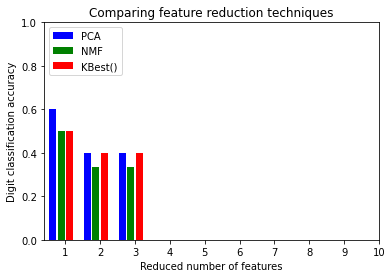

In [603]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest

print(__doc__)

pipe = Pipeline([
    # the reduce_dim stage is populated by the param_grid
    ('reduce_dim', 'passthrough'),
    ('classify', LogisticRegression())
])

N_FEATURES_OPTIONS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
C_OPTIONS = [1, 10, 100, 1000]
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7), NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
    {
        'reduce_dim': [SelectKBest()],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
]
reducer_labels = ['PCA', 'NMF', 'KBest()']


grid = GridSearchCV(pipe, n_jobs=1, cv= 5, param_grid=param_grid, scoring='precision')

grid.fit(features, labels)

mean_scores = np.array(grid.cv_results_['mean_test_score'])
# scores are in the order of param_grid iteration, which is alphabetical
mean_scores = mean_scores.reshape(len(C_OPTIONS), -1, len(N_FEATURES_OPTIONS))
# select score for best C
mean_scores = mean_scores.max(axis=0)
bar_offsets = (np.arange(len(N_FEATURES_OPTIONS)) *
               (len(reducer_labels) + 1) + .5)

plt.figure()
COLORS = 'bgrcmyk'
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

plt.title("Comparing feature reduction techniques")
plt.xlabel('Reduced number of features')
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel('Digit classification accuracy')
plt.ylim((0, 1))
plt.legend(loc='upper left')

plt.show()

### 3.4 get K-best features

In [803]:
num_features = 8

### 3.5 function using SelectKBest

In [804]:
def get_k_best(data_dict, features_list, k):
    """ runs scikit-learn's SelectKBest feature selection
        returns dict where keys=features, values=scores
    """
    data = featureFormat(data_dict, features_list)
    labels, features = targetFeatureSplit(data)

    k_best = SelectKBest(k=k)
    k_best.fit(features, labels)
    scores = k_best.scores_
    print(scores)
    unsorted_pairs = zip(features_list[1:], scores)
    sorted_pairs = list(reversed(sorted(unsorted_pairs, key=lambda x: x[1])))
    k_best_features = dict(sorted_pairs[:k])
    print ("{0} best features: {1}\n".format(k, k_best_features.keys(), scores))
    return k_best_features

=> Maybe appropriate stat test for classification. 

In [805]:
best_features = get_k_best(my_dataset, my_feature_list, num_features)

my_feature_list = [target_label] + list(set(best_features.keys()))


[20.79225205  0.22461127 11.45847658  2.1263278  24.81507973  6.09417331
  7.18405566  9.92218601  4.18747751  9.21281062  0.06549965 18.28968404
  8.77277773 24.18289868  0.16970095  5.24344971  2.38261211  8.58942073
  1.64634113  1.64634113  5.24344971  0.16970095  2.38261211  8.58942073
 16.40971255  9.10126874 10.78358471  0.05269769 22.11011023]
8 best features: dict_keys(['exercised_stock_options', 'total_stock_value', 'direction', 'bonus', 'salary', 'fraction_to_poi', 'deferred_income', 'bonus_to_salary'])



### 3.6 print features

In [806]:
print ("{0} selected features: {1}\n".format(len(my_feature_list) - 1, my_feature_list[1:]))

8 selected features: ['fraction_to_poi', 'direction', 'total_stock_value', 'exercised_stock_options', 'bonus', 'salary', 'bonus_to_salary', 'deferred_income']



### 3.7 extract the features specified in features_list


In [807]:
data = featureFormat(my_dataset, my_feature_list,sort_keys = True)

split into labels and features

In [808]:
labels, features = targetFeatureSplit(data)

### 3.8 scale features via min-max

In [809]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)

#### 3.9 Imputer strategy

from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer

model = make_pipeline(KNNImputer(),LogisticRegression())
params = {'knnimputer__n_neighbors' : [1, 2, 3, 4, 5, 6, 7, 8, 9,10]}
grid = GridSearchCV(model, param_grid=params,cv=5, scoring="precision")

grid.fit(features, labels)


grid.best_estimator_

imputer=KNNImputer(n_neighbors=1)

features=imputer.fit_transform(features)

## Task 4: Using algorithm

Please name your classifier clf for easy export below.   
Note that if you want to do PCA or other multi-stage operations,    
you'll need to use Pipelines. For more info:    
http://scikit-learn.org/stable/modules/pipeline.html     

Provided to give you a starting point. Try a variety of classifiers.   

### 4.1  Gaussian Naive Bayes Classifier

In [810]:
from sklearn.naive_bayes import GaussianNB
g_clf = GaussianNB()

### 4.2  Logistic Regression Classifier


In [28]:
from sklearn.linear_model import LogisticRegression

In [29]:
l_clf = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(C=1e-08, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, 
max_iter=100, multi_class='ovr', penalty='l2', random_state=42, solver='liblinear', tol=0.001, verbose=0))])

### 4.3  K-means Clustering

In [30]:
from sklearn.cluster import KMeans
k_clf = KMeans(n_clusters=2, tol=0.001)

### 4.4 Support Vector Machine Classifier

In [31]:
from sklearn.svm import SVC
s_clf = SVC(kernel='rbf', C=1000,gamma = 0.0001,random_state = 42, class_weight = 'balanced')

### 4.5 Random Forest


In [32]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(max_depth = 5,max_features = 'sqrt',n_estimators = 10, random_state = 42)

### 4.6 Gradient Boosting Classifier

In [33]:
from sklearn.ensemble  import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100,random_state = 42)

### 4.7 Decision Tree Classifier

In [34]:
from sklearn.tree import DecisionTreeClassifier

In [35]:
tre_clf=DecisionTreeClassifier(random_state=42)

### 4.8 KNeighborsClassifier

In [36]:
from sklearn.neighbors import KNeighborsClassifier

In [37]:
knn_clf = KNeighborsClassifier()

### 4.9 evaluate function


In [145]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

            train_test_split(features, labels, test_size=test_size)
        smt = SMOTE()
        features_train, labels_train= smt.fit_sample(features_train, labels_train)

In [769]:
def evaluate_clf(clf, features, labels, num_iters=1000, test_size=0.3):
    print (clf)
    accuracy = []
    precision = []
    recall = []
    first = True
    for trial in range(num_iters):
        features_train, features_test, labels_train, labels_test =\
            train_test_split(features, labels, test_size=test_size)
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        accuracy.append(accuracy_score(labels_test, predictions))
        precision.append(precision_score(labels_test, predictions))
        recall.append(recall_score(labels_test, predictions))
        if trial % 10 == 0:
            if first:
                sys.stdout.write('\nProcessing')
            sys.stdout.write('.')
            sys.stdout.flush()
            first = False

    print ("done.\n")
    print ("precision: {}".format(mean(precision)))
    print ("recall:    {}".format(mean(recall)))
    return mean(precision), mean(recall)

### 4.8 Evaluate all functions

In [811]:
evaluate_clf(l_clf, features, labels)


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(C=1e-08, multi_class='ovr', random_state=42,
                                    solver='liblinear', tol=0.001))])

Processing....................................................................................................done.

precision: 0.4130015096015096
recall:    0.464037481962482


(0.4130015096015096, 0.464037481962482)

In [739]:
evaluate_clf(g_clf, features, labels)
evaluate_clf(l_clf, features, labels)
evaluate_clf(k_clf, features, labels)
evaluate_clf(s_clf, features, labels)
#evaluate_clf(rf_clf, features, labels)
#evaluate_clf(gb_clf, features, labels)
evaluate_clf(tre_clf, features, labels)
evaluate_clf(knn_clf, features, labels)

GaussianNB()

Processing....................................................................................................done.

precision: 0.3634315281940282
recall:    0.41078362193362195
Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(C=1e-08, multi_class='ovr', random_state=42,
                                    solver='liblinear', tol=0.001))])

Processing....................................................................................................done.

precision: 0.3600283925826495
recall:    0.6068690115440115
KMeans(n_clusters=2, tol=0.001)

Processing....................................................................................................done.

precision: 0.32768285854019885
recall:    0.39022673160173155
SVC(C=1000, class_weight='balanced', gamma=0.0001, random_state=42)

Processing....................................................................................................done.

prec

(0.23450102022160846, 0.4146099567099567)

=> Rajouter fonction print best

### 5. Quick hyperparameters tuning

In [42]:
 from sklearn.model_selection import GridSearchCV

#### 5.1 Decision Tree

In [47]:
clf_parameters = { 'criterion': ['gini', 'entropy'],
                   'max_depth': [None, 1, 2, 4, 5, 10, 15, 20],
                   'min_samples_split': [2, 4, 6, 8, 10, 20, 30, 40],
                   'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 10, 20, 30] }

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=67)
clf = GridSearchCV(DecisionTreeClassifier(), param_grid = clf_parameters, cv = cv, scoring = 'f1')
clf.fit(features,labels)

best_clf_parameters = clf.best_estimator_
best_clf_parameters

DecisionTreeClassifier(criterion='entropy')

In [101]:
clf_best_tree=DecisionTreeClassifier(criterion='entropy')

In [186]:
best_tree=evaluate_clf(clf_best_tree,features,labels)

DecisionTreeClassifier(criterion='entropy')

Processing....................................................................................................done.

precision: 0.28556813603063597
recall:    0.28008943001443004


#### 5.2 Log Regression

In [630]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PolynomialFeatures

import numpy as np

In [834]:
    from imblearn.pipeline import Pipeline
    min_slc=MinMaxScaler()
    std_slc = StandardScaler()
    rob_slc= RobustScaler()
    pol_slc= PolynomialFeatures()
    logistic_Reg = LogisticRegression(tol=0.001)
    smote=SMOTETomek(sampling_strategy=0.7)
    #Choose Standard Scaler in pipeline
    pipe =Pipeline(steps=[('std_slc', std_slc),('logistic_Reg', logistic_Reg)])

 Previous used parameters :   
    LogisticRegression(C=1e-08, multi_class='ovr', random_state=42,
                                    solver='liblinear', tol=0.001))])

In [ ]:
        smt = SMOTETomek()
        features_train, labels_train= smt.fit_sample(features_train, labels_train)

In [835]:
# define models and parameters

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ["l1","l2","elasticnet","none"]
c_values = np.logspace(-4, 4, 50)
class_weight=['balanced',None]
multi_class=["ovr"]

# define grid search
grid = dict(logistic_Reg__solver=solvers,logistic_Reg__penalty=penalty,logistic_Reg__C=c_values,logistic_Reg__class_weight=class_weight,logistic_Reg__multi_class=multi_class)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, train_size=0.7,random_state=1)
grid_search = GridSearchCV(estimator=pipe, param_grid=grid, n_jobs=-1, cv=cv,scoring = 'f1')
grid_result = grid_search.fit(features, labels)

In [836]:
grid_result.best_estimator_

Pipeline(steps=[('std_slc', StandardScaler()),
                ('logistic_Reg',
                 LogisticRegression(C=0.004291934260128779,
                                    class_weight='balanced', multi_class='ovr',
                                    solver='newton-cg', tol=0.001))])

In [838]:
clf_best_log_f1=Pipeline(steps=[('std_slc', StandardScaler()),
                ('logistic_Reg',
                 LogisticRegression(C=0.004291934260128779,
                                    class_weight='balanced', multi_class='ovr',
                                    solver='newton-cg', tol=0.001))])

In [440]:
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

In [843]:
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ["l1","l2","elasticnet","none"]
c_values = np.logspace(-4, 4, 50)
class_weight=['balanced']
multi_class=["ovr"]
scoring = {'precision_macro': make_scorer(precision_score, average='weighted')}

# define grid search
grid = dict(logistic_Reg__solver=solvers,logistic_Reg__penalty=penalty,logistic_Reg__C=c_values,logistic_Reg__class_weight=class_weight,logistic_Reg__multi_class=multi_class)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, train_size=0.7,random_state=1)
grid_search = GridSearchCV(estimator=pipe, param_grid=grid, n_jobs=-1, cv=cv,scoring=scoring, refit='precision_macro',return_train_score=True)
grid_result = grid_search.fit(features, labels)

In [844]:
grid_result.best_estimator_

Pipeline(steps=[('std_slc', StandardScaler()),
                ('logistic_Reg',
                 LogisticRegression(C=0.004291934260128779,
                                    class_weight='balanced', multi_class='ovr',
                                    solver='liblinear', tol=0.001))])

In [847]:
clf_best_log_precision=Pipeline(steps=[('std_slc', StandardScaler()),
                ('logistic_Reg',
                 LogisticRegression(C=0.004291934260128779,
                                    class_weight='balanced', multi_class='ovr',
                                    solver='liblinear', tol=0.001))])

In [99]:
# Evaluate

In [839]:
evaluate_clf(clf_best_log_f1,features,labels)

Pipeline(steps=[('std_slc', StandardScaler()),
                ('logistic_Reg',
                 LogisticRegression(C=0.004291934260128779,
                                    class_weight='balanced', multi_class='ovr',
                                    solver='newton-cg', tol=0.001))])

Processing....................................................................................................done.

precision: 0.3766516851526526
recall:    0.5312869047619047


(0.3766516851526526, 0.5312869047619047)

In [848]:
evaluate_clf(clf_best_log_precision,features,labels)

Pipeline(steps=[('std_slc', StandardScaler()),
                ('logistic_Reg',
                 LogisticRegression(C=0.004291934260128779,
                                    class_weight='balanced', multi_class='ovr',
                                    solver='liblinear', tol=0.001))])

Processing....................................................................................................done.

precision: 0.3147485240546907
recall:    0.8268116522366522


(0.3147485240546907, 0.8268116522366522)

avoir une faible preicision, c'est l'ago qui s'est trompé en disignant des personnes innocentes en personne frauduleuse. 
Donc il y a des caracteristiques pour lesquels, l'algo se trompe

In [514]:
from sklearn.neural_network import MLPClassifier
mlp_clf = MLPClassifier(random_state=1, max_iter=10)
evaluate_clf(mlp_clf,features,labels)

MLPClassifier(max_iter=10, random_state=1)

Processing....................................................................................................done.

precision: 0.0
recall:    0.0


(0.0, 0.0)

#### 5.3 Try staking the 2 models

In [190]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [215]:
clf_best_tree=BalancedRandomForestClassifier(max_depth= None, n_estimators = 5, random_state = 80)

In [126]:
#pip install mlxtend  

In [109]:
from mlxtend.classifier import StackingClassifier

In [672]:
m_clf = StackingClassifier(classifiers=[clf_best_log_f1,clf_best_log_precision],use_probas=True,meta_classifier=clf_best_log_precision)

In [673]:
evaluate_clf(m_clf,features,labels)

StackingClassifier(classifiers=[LogisticRegression(C=0.0062505519252739694,
                                                   class_weight='balanced',
                                                   multi_class='ovr',
                                                   solver='newton-cg',
                                                   tol=0.001),
                                LogisticRegression(C=0.0006551285568595509,
                                                   class_weight='balanced',
                                                   multi_class='ovr',
                                                   solver='liblinear',
                                                   tol=0.001)],
                   meta_classifier=LogisticRegression(C=0.0006551285568595509,
                                                      class_weight='balanced',
                                                      multi_class='ovr',
                                                      so

(0.41848376484626487, 0.5354443001443001)

Select Logistic Regression as final algorithm

In [849]:
clf = l_clf

dump your classifier, dataset and features_list so   
anyone can run/check your results

In [850]:
pickle.dump(clf, open("../final_project/my_classifier.pkl", "wb"))
pickle.dump(my_dataset, open("../final_project/my_dataset.pkl", "wb"))
pickle.dump(my_feature_list, open("../final_project/my_feature_list.pkl", "wb"))

### Task 5: Tune your classifier

In [851]:
my_feature_list

['poi',
 'fraction_to_poi',
 'direction',
 'total_stock_value',
 'exercised_stock_options',
 'bonus',
 'salary',
 'bonus_to_salary',
 'deferred_income']


 Task 5: Tune your classifier to achieve better than .42 precision and recall   
 using our testing script. Check the tester.py script in the final project  
 folder for details on the evaluation method, especially the test_classifier   
 function. Because of the small size of the dataset, the script uses   
 stratified shuffle split cross validation. For more info:   
 http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html  

Example starting point. Try investigating other evaluation techniques!

features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

### Task 6: Dump your classifier, dataset, and features_list

Task 6: Dump your classifier, dataset, and features_list so anyone can   
check your results. You do not need to change anything below, but make sure  
that the version of poi_id.py that you submit can be run on its own and   
generates the necessary .pkl files for validating your results.  

In [852]:
import tester
tester.dump_classifier_and_data(clf, my_dataset, my_feature_list)
tester.main()

Pipeline(steps=[('std_slc', StandardScaler()),
                ('logistic_Reg',
                 LogisticRegression(C=0.004291934260128779,
                                    class_weight='balanced', multi_class='ovr',
                                    solver='liblinear', tol=0.001))])
	Accuracy: 0.73214	Precision: 0.32708	Recall: 0.82750	F1: 0.46884	F2: 0.63361
	Total predictions: 14000	True positives: 1655	False positives: 3405	False negatives:  345	True negatives: 8595

